# Financial Sentiment Analysis Tool

## Business Objective
Automatically analyze sentiment in SEC 10-K filings to:
- **Detect Red Flags**: Identify risky or misleading narratives
- **Assess Tone Consistency**: Find inconsistencies across report sections
- **Support Decision Making**: Provide auditors and investors with actionable insights
- **Scalable Reporting**: Process multiple companies efficiently

## How It Works
1. Load SEC filing sections (MD&A, Risk Factors, etc.)
2. Analyze sentiment using FinBERT (financial NLP model)
3. Compare sentiments across sections to find inconsistencies
4. Flag high-risk patterns (over-optimism, distress indicators)
5. Generate actionable business insights

## Stakeholder Requirements & Use Case Analysis

This tool supports three primary stakeholder groups with different analytical needs:

### 👥 AUDITORS
**Trigger**: Initial audit planning phase  
**Questions**: 
- Are all sections consistent in tone?
- Which sections require deeper audit focus?
- Are there red flags for misstatement?

**Expected Output**: Risk prioritization report, section-level sentiment comparison

### 👥 INVESTORS  
**Trigger**: Investment research & due diligence  
**Questions**:
- How does this company's tone compare to peers?
- Is management's tone aligned with financial performance?
- Are there hidden risks in the narrative?

**Expected Output**: Comparative sentiment dashboard, outlier identification

### 👥 REGULATORS
**Trigger**: Ongoing monitoring and enforcement  
**Questions**:
- Which companies show anomalous narrative tone?
- Are companies making misleading claims?
- Which filings warrant investigation?

**Expected Output**: Risk-scored anomaly reports, trend analysis

**For detailed requirements analysis, see**: `REQUIREMENTS_ANALYSIS.md`


## Setup Instructions

### Installation & Requirements
Before running this notebook, ensure you have:

1. **Python 3.8+** installed
2. **Jupyter Notebook** or **JupyterLab**
3. **Sample data files** in the `data/` directory (JSON format SEC filings)

### Quick Start

```bash
# 1. Install dependencies
pip install -r requirements.txt

# 2. Verify setup
jupyter notebook financial_sentiment_analysis.ipynb
```

### File Structure
```
Sentiment-Analyzer/
├── financial_sentiment_analysis.ipynb  # Main interactive notebook (this file)
├── sentiment_analysis.py                # Core NLP module
├── batch_analysis.py                    # Batch processing module
├── requirements.txt                     # Python dependencies
├── data/                                # Directory for SEC filing JSON files
│   └── *.json                          # Sample company 10-K filings
├── output/                              # Results directory (auto-created)
│   └── batch_analysis_*.csv            # Batch results
├── USE_CASE.md                         # Business use case specification
└── REQUIREMENTS_ANALYSIS.md            # Detailed stakeholder requirements
```

### Data Source
- **Format**: JSON files containing structured SEC 10-K sections
- **Example sections**: Item 7 (MD&A), Item 1A (Risk Factors)
- **Location**: Place JSON files in the `data/` directory
- **Sample files**: Included in the repository for demonstration

### Expected Runtime
- Single filing analysis: 2-3 minutes (first run with model download)
- Batch processing (3+ files): 5-10 minutes total
- *Note: First execution downloads FinBERT model (~500MB) from Hugging Face*

### Troubleshooting

**Q: "No module named 'transformers'"**
```bash
pip install transformers torch
```

**Q: "No JSON files found in data/ directory"**
- Ensure sample JSON files are in the `data/` folder
- Files should contain 'item_7' and/or 'item_1A' sections

**Q: Model download is slow**
- FinBERT model (~500MB) downloads on first use
- Subsequent runs use cached version (no redownload)

**For more details, see**: `REQUIREMENTS_ANALYSIS.md` and `USE_CASE.md`


In [22]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from typing import Dict, List, Any, Tuple
import json
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentiment_analysis import FinancialSentimentAnalyzer, load_filing_data, create_visualization
from batch_analysis import process_batch

# Configure matplotlib and seaborn for performance and aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Define project paths (relative to notebook location)
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "output"

# Ensure output directory exists
OUTPUT_DIR.mkdir(exist_ok=True)

# Session header
print("=" * 70)
print("Financial Sentiment Analysis - Interactive Demo")
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Project root: {PROJECT_ROOT}")
print("=" * 70)

Financial Sentiment Analysis - Interactive Demo
Session started: 2025-12-07 15:16:55
Project root: /Users/annageiser/Desktop/Sentiment-Analyzer


## Step 1: Setup Environment

In [23]:
# Load sample SEC filing with multiple sections
# Find first available JSON file in data directory
available_samples = list(DATA_DIR.glob("*.json"))

if available_samples:
    SAMPLE_FILE = str(available_samples[0])
    print(f"Using sample file: {available_samples[0].name}")
else:
    SAMPLE_FILE = str(DATA_DIR / "8670_10K_2021_0000008670-21-000027.json")
    print(f"⚠️  Warning: No sample files found in {DATA_DIR}")

SECTIONS_OF_INTEREST = ['item_7', 'item_1A']

try:
    filing_data = load_filing_data(SAMPLE_FILE, SECTIONS_OF_INTEREST)
    print("=" * 70)
    print(f"✓ Loaded filing data with {len(filing_data)} sections")
    print(f"  Available sections: {', '.join(filing_data.keys())}")
    print("=" * 70)
    
    # Display section sizes
    for section, text in filing_data.items():
        print(f"  {section}: {len(text):,} characters")
except FileNotFoundError:
    print(f"⚠️  File not found: {SAMPLE_FILE}")
    print(f"   Please ensure JSON files are in: {DATA_DIR}")
    filing_data = {}

2025-12-07 15:16:58,872 - sentiment_analysis - INFO - Loaded 2 sections from /Users/annageiser/Desktop/Sentiment-Analyzer/data/50471_10K_2021_0001654954-21-010502.json


Using sample file: 50471_10K_2021_0001654954-21-010502.json
✓ Loaded filing data with 2 sections
  Available sections: item_7, item_1A
  item_7: 27,532 characters
  item_1A: 31,193 characters


## Step 2: Load Company Filing

In [24]:
# Initialize analyzer (one-time expensive operation)
print("=" * 70)
print("\n🔧 Initializing Sentiment Analyzer...")
analyzer = FinancialSentimentAnalyzer()
print("✅ Ready to analyze filings")
print("=" * 70)

2025-12-07 15:17:01,462 - sentiment_analysis - INFO - Loading FinBERT model: ProsusAI/finbert
2025-12-07 15:17:01,464 - sentiment_analysis - INFO - Using device: CPU
2025-12-07 15:17:01,464 - sentiment_analysis - INFO - Using device: CPU
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f1c4310b-81ab-47e7-9f4d-85a978a67c3a)')' thrown while requesting HEAD https://huggingface.co/ProsusAI/finbert/resolve/main/tokenizer_config.json
2025-12-07 15:17:01,477 - huggingface_hub.utils._http - WARNING - '(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f1c4310b-81ab-47e7-9f4d-85a978a67c3a)')' thrown while requesting HEAD https://huggingface.co/ProsusAI/finbert/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
2025-12-07 15:17:01,479 - huggingface_hub.utils._http - WARNING - Retrying in 1s [Retry 1/5].
'(ProtocolError('Connection aborted.',


🔧 Initializing Sentiment Analyzer...


2025-12-07 15:17:03,848 - sentiment_analysis - INFO - FinBERT model loaded successfully
2025-12-07 15:17:03,849 - sentiment_analysis - INFO - Analyzer initialized with backend: FinBERT (Transformers)
2025-12-07 15:17:03,849 - sentiment_analysis - INFO - Analyzer initialized with backend: FinBERT (Transformers)


✅ Ready to analyze filings


## Step 3: Key Question - Is the Tone Consistent Across Sections?

In [25]:
if filing_data:
    print("=" * 70)
    print("\n📊 SENTIMENT COMPARISON - Cross-Section Analysis")
    print("=" * 70)
    comparison_data = []
    
    for section_name, section_text in filing_data.items():
        section_results = analyzer.analyze_text(section_text)
        section_agg = analyzer.aggregate_sentiment(section_results)
        
        comparison_data.append({
            'Section': section_name.replace('item_', 'Item ').upper(),
            'Sentiment': section_agg['label'],
            'Score': f"{section_agg['score']:.3f}",
            'Confidence': f"{section_agg['confidence']:.3f}",
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("=" * 70)
    
    # Check for inconsistencies
    sentiments = [d['Sentiment'] for d in comparison_data]
    if len(set(sentiments)) > 1:
        print(f"⚠️  ALERT: Sentiment differs across sections - potential inconsistency detected!")
        print("=" * 70)
    else:
        print(f"✅ Consistent tone: All sections show {sentiments[0]} sentiment")
        print("=" * 70)
else:
    print("⚠️  No filing data available")
    print("=" * 70)

2025-12-07 15:17:22,793 - sentiment_analysis - INFO - Analyzing text of length 27532 characters



📊 SENTIMENT COMPARISON - Cross-Section Analysis


2025-12-07 15:17:30,334 - sentiment_analysis - INFO - Analyzing text of length 31193 characters


Section Sentiment Score Confidence
 ITEM 7   Neutral 0.022      1.000
ITEM 1A  Negative 0.455      1.000
⚠️  ALERT: Sentiment differs across sections - potential inconsistency detected!


### Visual: Sentiment Scores by Section

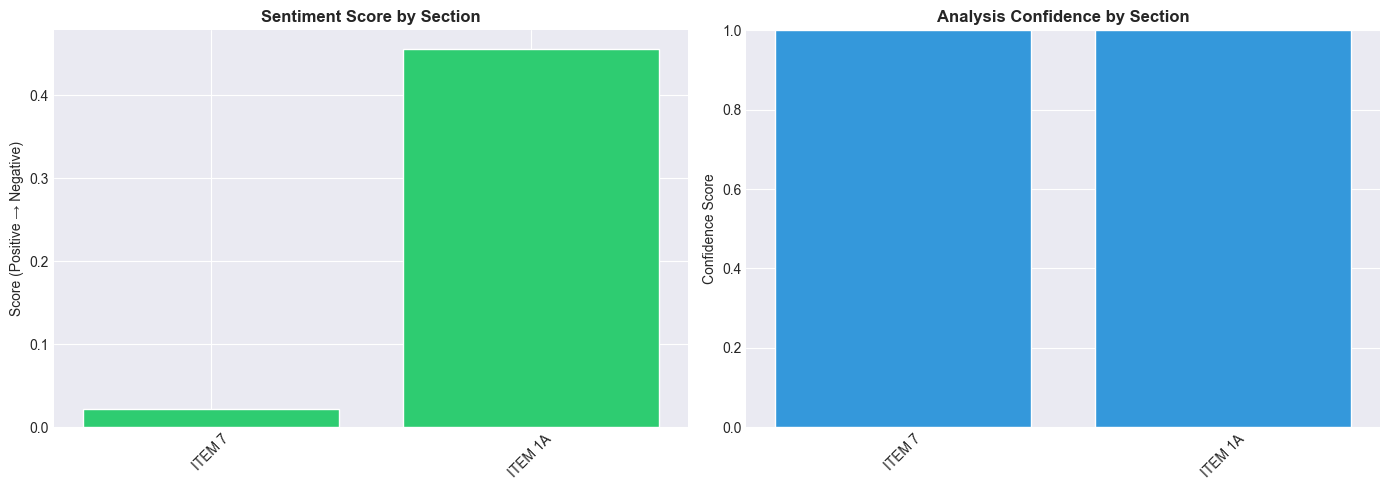

In [26]:
print("=" * 70)

if 'comparison_df' in locals() and len(comparison_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Convert Score and Confidence to float for plotting
    comparison_df['Score_float'] = comparison_df['Score'].astype(float)
    comparison_df['Confidence_float'] = comparison_df['Confidence'].astype(float)
    
    # Sentiment scores
    colors = ['#2ecc71' if x > 0 else '#e74c3c' if x < 0 else '#95a5a6' 
              for x in comparison_df['Score_float']]
    axes[0].bar(comparison_df['Section'], comparison_df['Score_float'], color=colors)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_title('Sentiment Score by Section', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Score (Positive → Negative)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Confidence scores
    axes[1].bar(comparison_df['Section'], comparison_df['Confidence_float'], color='#3498db')
    axes[1].set_title('Analysis Confidence by Section', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Confidence Score')
    axes[1].set_ylim([0, 1.0])
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Insufficient data for visualization")

print("=" * 70)

## Step 4: Key Question - Are There Red Flags or Risk Indicators?

In [27]:
def assess_business_risks(sentiment_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Assess financial risks from business perspective.
    
    Returns: Dictionary with risk level, specific risks, and recommendations
    """
    risks = []
    severity = "LOW"
    
    positive_ratio = sentiment_results.get('positive_ratio', 0)
    negative_ratio = sentiment_results.get('negative_ratio', 0)
    confidence = sentiment_results.get('confidence', 0)
    
    # Risk 1: Over-optimism (potential misleading statements)
    if positive_ratio > 0.70:
        risks.append("🔴 OVER-OPTIMISM: Unusually positive tone may mask underlying issues")
        severity = "HIGH"
    
    # Risk 2: Distress signals
    if negative_ratio > 0.60:
        risks.append("🔴 DISTRESS SIGNALS: High negative sentiment may indicate financial problems")
        severity = "HIGH"
    
    # Risk 3: Low confidence (vague/unclear disclosures)
    if confidence < 0.30:
        risks.append("🟠 VAGUE LANGUAGE: Low confidence suggests unclear or inconsistent disclosures")
        severity = "MEDIUM" if severity == "LOW" else severity
    
    # Risk 4: Mixed messaging
    if 0.35 < positive_ratio < 0.65 and 0.35 < negative_ratio < 0.65:
        risks.append("🟡 MIXED SIGNALS: Conflicting narratives - company is hedging statements")
        severity = "MEDIUM" if severity == "LOW" else severity
    
    return {
        'severity': severity,
        'risks': risks if risks else ["✅ LOW RISK: Consistent, clear, moderate tone"],
        'confidence': confidence
    }


# Analyze all sections for risks
if filing_data:
    print("\n🚨 RISK ASSESSMENT - Executive Summary")
    print("=" * 70)
    
    all_risks = []
    for section_name, section_text in filing_data.items():
        section_results = analyzer.analyze_text(section_text)
        section_agg = analyzer.aggregate_sentiment(section_results)
        section_risks = assess_business_risks(section_agg)
        
        print(f"\n📌 {section_name.replace('item_', 'Item ').upper()}")
        print(f"   Risk Level: {section_risks['severity']} | Confidence: {section_risks['confidence']:.1%}")
        for risk in section_risks['risks']:
            print(f"   {risk}")
        all_risks.append(section_risks)
    
    # Overall assessment
    print("\n" + "=" * 70)
    print("🎯 OVERALL ASSESSMENT")
    overall_severity = max([r['severity'] for r in all_risks], key=lambda x: {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}[x])
    print(f"Risk Level: {overall_severity}")
    
    if overall_severity == "HIGH":
        print("⚠️  RECOMMENDATION: Conduct thorough audit of disclosure statements")
    elif overall_severity == "MEDIUM":
        print("⚠️  RECOMMENDATION: Review specific sections flagged above")
    else:
        print("✅ RECOMMENDATION: Standard review procedures sufficient")
else:
    print("⚠️  No filing data available")

2025-12-07 15:19:34,045 - sentiment_analysis - INFO - Analyzing text of length 27532 characters



🚨 RISK ASSESSMENT - Executive Summary


2025-12-07 15:19:42,274 - sentiment_analysis - INFO - Analyzing text of length 31193 characters



📌 ITEM 7
   Risk Level: LOW | Confidence: 100.0%
   ✅ LOW RISK: Consistent, clear, moderate tone

📌 ITEM 1A
   Risk Level: LOW | Confidence: 100.0%
   ✅ LOW RISK: Consistent, clear, moderate tone

🎯 OVERALL ASSESSMENT
Risk Level: LOW
✅ RECOMMENDATION: Standard review procedures sufficient

📌 ITEM 1A
   Risk Level: LOW | Confidence: 100.0%
   ✅ LOW RISK: Consistent, clear, moderate tone

🎯 OVERALL ASSESSMENT
Risk Level: LOW
✅ RECOMMENDATION: Standard review procedures sufficient


## Step 5: Deep Dive - Detailed MD&A Analysis

In [28]:
if filing_data and 'item_7' in filing_data:
    print("\n📋 DETAILED MD&A ANALYSIS (Management Discussion & Analysis)")
    print("=" * 70)
    
    mdna_text = filing_data['item_7']
    mdna_results = analyzer.analyze_text(mdna_text)
    mdna_aggregate = analyzer.aggregate_sentiment(mdna_results)
    
    print(f"\nText Length: {len(mdna_text):,} characters")
    print(f"Chunks Analyzed: {len(mdna_results)}")
    
    print(f"\n📊 Sentiment Breakdown:")
    distribution = mdna_aggregate['sentiment_distribution']
    total = sum(distribution.values())
    for sentiment, count in sorted(distribution.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total * 100) if total > 0 else 0
        print(f"   {sentiment:12s}: {count:3d} chunks ({percentage:5.1f}%)")
    
    print(f"\n🎯 Overall Assessment:")
    print(f"   Sentiment: {mdna_aggregate['label']}")
    print(f"   Score: {mdna_aggregate['score']:.3f} (positive=1.0, negative=-1.0)")
    print(f"   Confidence: {mdna_aggregate['confidence']:.1%}")
    
    # Save for downstream analysis
    mdna_analysis = {
        'results': mdna_results,
        'aggregate': mdna_aggregate
    }
else:
    print("⚠️  MD&A section not available")

2025-12-07 15:20:26,841 - sentiment_analysis - INFO - Analyzing text of length 27532 characters



📋 DETAILED MD&A ANALYSIS (Management Discussion & Analysis)

Text Length: 27,532 characters
Chunks Analyzed: 41

📊 Sentiment Breakdown:
   Neutral     :  28 chunks ( 68.3%)
   Negative    :   7 chunks ( 17.1%)
   Positive    :   6 chunks ( 14.6%)
   ERROR       :   0 chunks (  0.0%)

🎯 Overall Assessment:
   Sentiment: Neutral
   Score: 0.022 (positive=1.0, negative=-1.0)
   Confidence: 100.0%

Text Length: 27,532 characters
Chunks Analyzed: 41

📊 Sentiment Breakdown:
   Neutral     :  28 chunks ( 68.3%)
   Negative    :   7 chunks ( 17.1%)
   Positive    :   6 chunks ( 14.6%)
   ERROR       :   0 chunks (  0.0%)

🎯 Overall Assessment:
   Sentiment: Neutral
   Score: 0.022 (positive=1.0, negative=-1.0)
   Confidence: 100.0%


## Step 6: Business Actionable Insights

In [29]:
print("\n📌 KEY BUSINESS INSIGHTS")
print("=" * 70)

insights = [
    ("AUDITORS", [
        "Use sentiment inconsistency detection to identify sections requiring deeper audit",
        "Flag unusual optimism in problematic business segments",
        "Verify claims in sections with vague or conflicting language"
    ]),
    ("INVESTORS", [
        "Compare sentiment tone to financial metrics (income, cash flow) for coherence",
        "Watch for over-optimism relative to risk factor disclosures",
        "Identify companies hedging negative news with cautious language"
    ]),
    ("REGULATORS", [
        "Monitor for systematically misleading narratives across filings",
        "Compare sentiment trends year-over-year for consistency",
        "Cross-check narrative claims against quantitative financial data"
    ])
]

for stakeholder, use_cases in insights:
    print(f"\n👥 {stakeholder}")
    for i, case in enumerate(use_cases, 1):
        print(f"   {i}. {case}")


📌 KEY BUSINESS INSIGHTS

👥 AUDITORS
   1. Use sentiment inconsistency detection to identify sections requiring deeper audit
   2. Flag unusual optimism in problematic business segments
   3. Verify claims in sections with vague or conflicting language

👥 INVESTORS
   1. Compare sentiment tone to financial metrics (income, cash flow) for coherence
   2. Watch for over-optimism relative to risk factor disclosures
   3. Identify companies hedging negative news with cautious language

👥 REGULATORS
   1. Monitor for systematically misleading narratives across filings
   2. Compare sentiment trends year-over-year for consistency
   3. Cross-check narrative claims against quantitative financial data


## Step 7: Scale Up - Batch Processing Multiple Companies

In [30]:
from batch_analysis import process_batch
from pathlib import Path
from datetime import datetime

print("\n🚀 BATCH PROCESSING - Multiple Companies")
print("=" * 70)

# Demo: First show single filing analysis (already done above)
print("\n📌 SINGLE FILING (Already Analyzed)")
print("-" * 70)
print(f"File: {SAMPLE_FILE}")
print(f"Overall Risk Level: {overall_severity}")
print("✅ Use this when auditing or analyzing a specific company\n")

# Demo: Now show batch processing capability
data_dir = Path("data")
output_dir = Path("output")
available_files = list(data_dir.glob("*.json"))

# Ensure output directory exists
output_dir.mkdir(exist_ok=True)

if len(available_files) > 1:
    print(f"📌 BATCH PROCESSING ({len(available_files)} companies found)")
    print("-" * 70)
    print("Processing all filings in data/ directory...\n")
    
    # Generate timestamped output filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"output/batch_analysis_{timestamp}.csv"
    
    # Run batch analysis
    process_batch(
        input_dir='data/',
        output_file=output_file,
        sections=['item_7', 'item_1A']
    )
    
    # Load and display results
    batch_df = pd.read_csv(output_file)
    print("\n✅ Batch Analysis Results:")
    print("-" * 70)
    
    # Show summary statistics
    if 'overall_sentiment' in batch_df.columns:
        print(f"\nProcessed {len(batch_df['company_id'].unique())} companies")
        print(f"Analyzed {len(batch_df)} section-level entries")
        print(f"\nResults saved to: {output_file}")
        
        # Display sample results
        print("\nSample Results (first 10 entries):")
        display_cols = ['company_id', 'section', 'overall_sentiment', 'sentiment_score', 'confidence']
        available_cols = [col for col in display_cols if col in batch_df.columns]
        print(batch_df[available_cols].head(10).to_string(index=False))
        
        print("\n✅ Use batch processing when:")
        print("   - Analyzing industry trends")
        print("   - Comparing multiple companies")
        print("   - Identifying outliers (unusually optimistic/pessimistic)")
        print("   - Generating regulatory reports")
    
else:
    print("📌 BATCH PROCESSING")
    print("-" * 70)
    print(f"Only {len(available_files)} file(s) available in data/ directory")
    print("\n✅ To run batch processing:")
    print("   1. Add more SEC filings to data/ directory")
    print("   2. Run: process_batch(")
    print("         input_dir='data/',")
    print("         output_file='output/batch_results.csv',")
    print("         sections=['item_7', 'item_1A']")
    print("      )")
    print("\n✅ Batch processing provides:")
    print("   - Cross-company sentiment comparison")
    print("   - Industry trend analysis")
    print("   - Risk outlier identification")
    print("   - Exportable results (CSV in output/ folder)")

2025-12-07 15:22:00,960 - batch_analysis - INFO - Found 3 files to process
2025-12-07 15:22:00,961 - sentiment_analysis - INFO - Loading FinBERT model: ProsusAI/finbert
2025-12-07 15:22:00,961 - sentiment_analysis - INFO - Loading FinBERT model: ProsusAI/finbert
2025-12-07 15:22:00,962 - sentiment_analysis - INFO - Using device: CPU
2025-12-07 15:22:00,962 - sentiment_analysis - INFO - Using device: CPU



🚀 BATCH PROCESSING - Multiple Companies

📌 SINGLE FILING (Already Analyzed)
----------------------------------------------------------------------
File: /Users/annageiser/Desktop/Sentiment-Analyzer/data/50471_10K_2021_0001654954-21-010502.json
Overall Risk Level: LOW
✅ Use this when auditing or analyzing a specific company

📌 BATCH PROCESSING (3 companies found)
----------------------------------------------------------------------
Processing all filings in data/ directory...



2025-12-07 15:22:02,216 - sentiment_analysis - INFO - FinBERT model loaded successfully
2025-12-07 15:22:02,217 - sentiment_analysis - INFO - Analyzer initialized with backend: FinBERT (Transformers)
2025-12-07 15:22:02,217 - batch_analysis - INFO - Processing 50471_10K_2021_0001654954-21-010502.json (1/3)
2025-12-07 15:22:02,220 - sentiment_analysis - INFO - Loaded 2 sections from data/50471_10K_2021_0001654954-21-010502.json
2025-12-07 15:22:02,217 - sentiment_analysis - INFO - Analyzer initialized with backend: FinBERT (Transformers)
2025-12-07 15:22:02,217 - batch_analysis - INFO - Processing 50471_10K_2021_0001654954-21-010502.json (1/3)
2025-12-07 15:22:02,220 - sentiment_analysis - INFO - Loaded 2 sections from data/50471_10K_2021_0001654954-21-010502.json
2025-12-07 15:22:02,224 - sentiment_analysis - INFO - Analyzing text of length 27532 characters
2025-12-07 15:22:02,224 - sentiment_analysis - INFO - Analyzing text of length 27532 characters
2025-12-07 15:22:09,551 - sentimen


BATCH PROCESSING SUMMARY
Total files found: 3
Successful analyses: 6
Errors encountered: 0

Average sentiment score: 0.298
Average confidence: 1.000

Sentiment distribution:
overall_sentiment
Negative    4
Neutral     1
Positive    1
Name: count, dtype: int64

✅ Batch Analysis Results:
----------------------------------------------------------------------

Processed 3 companies
Analyzed 6 section-level entries

Results saved to: output/batch_analysis_20251207_152200.csv

Sample Results (first 10 entries):
 company_id section overall_sentiment  sentiment_score  confidence
      50471  item_7           Neutral         0.022237         1.0
      50471 item_1A          Negative         0.454703         1.0
      78749  item_7          Negative         0.123740         1.0
      78749 item_1A          Negative         0.612121         1.0
       8670  item_7          Positive         0.117769         1.0
       8670 item_1A          Negative         0.458607         1.0

✅ Use batch proces